In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim


img_channels = 3
img_size = 64
patch_size = 64
embed_dim = 64
batch_size = 16
num_patches = 1
dropout = 0.0


def split_into_blocks(image, n_h, n_w):
    """
    Разделяет изображение на n_h × n_w блоков.

    Args:
        image (torch.Tensor): Тензор (C, H, W).
        n_h (int): Количество частей по высоте.
        n_w (int): Количество частей по ширине.

    Returns:
        torch.Tensor: Тензор (n_h * n_w, C, H//n_h, W//n_w).
    """
    c, h, w = image.shape
    block_h = h // n_h
    block_w = w // n_w

    # Разделение на блоки с помощью unfold
    blocks = image.unfold(1, block_h, block_h).unfold(2, block_w, block_w)
    blocks = blocks.contiguous().view(-1, c, block_h, block_w)

    return blocks

# Пример:
image = torch.randn(3, 256, 256)  # (C, H, W)
blocks = split_into_blocks(image, 4, 4)  # 4x4=16 блоков
print(blocks.shape)  # (16, 3, 64, 64)



def patches():
  patches = blocks.contiguous().view(batch_size, img_channels, -1, patch_size * patch_size)
  patches = patches.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, img_channels * patch_size * patch_size)
  # print("patches shape after flatten:", patches.shape)
  return patches


def lin_projection(img_channels,patch_size,embed_dim):
  projection = nn.Linear(img_channels * patch_size * patch_size, embed_dim)
  embedded_patches = projection(patches)
  #print("embedded_patches shape:", embedded_patches.shape)
  return embedded_patches


def cl_tok(embedded_patches):
  cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
  print(cls_token.shape)
  cls_tokens = cls_token.expand(batch_size, -1, -1)
  tokens = torch.cat([cls_tokens, embedded_patches], dim=1)
  print(tokens.shape)
  return tokens


def posit():
  pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))  # (1, N+1, D)

  # 6. Добавляем позиционные эмбеддинги
  tokens = tokens + pos_embedding  # (B, N+1, D)
  #print(tokens.shape)
  return tokens


import torch
import torch.nn as nn

class PatchEmbeddingWithCLS(nn.Module):
    """
    Изображение -> последовательность токенов (CLS + патчи) с позиционными эмбеддингами.

    Вход:  x (B, C, H, W)
    Выход: tokens (B, N+1, D), где N = (H/P)*(W/P)
    """
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        assert img_size % patch_size == 0, "img_size должно делиться на patch_size"
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim

        # Кол-во патчей
        self.num_patches_h = img_size // patch_size
        self.num_patches_w = img_size // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        patch_dim = in_chans * patch_size * patch_size

        # Линейная проекция патчей
        self.proj = nn.Linear(patch_dim, embed_dim)

        # CLS-токен (обучаемый)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Позиционные эмбеддинги (обучаемые) для CLS + всех патчей
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))

        # Инициализация
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.xavier_uniform_(self.proj.weight)
        if self.proj.bias is not None:
            nn.init.zeros_(self.proj.bias)

    def _img_to_patches(self, x):
        """
        Превращает (B, C, H, W) в (B, N, patch_dim), где patch_dim = C*P*P.
        """
        B, C, H, W = x.shape
        P = self.patch_size
        # (B, C, Nh, Nw, P, P)
        patches = x.unfold(2, P, P).unfold(3, P, P)
        # -> (B, C, Nh*Nw, P*P)
        patches = patches.contiguous().view(B, C, -1, P * P)
        # -> (B, Nh*Nw, C, P*P)
        patches = patches.permute(0, 2, 1, 3).contiguous()
        # -> (B, N, C*P*P)
        patches = patches.view(B, -1, C * P * P)
        return patches  # (B, N, patch_dim)

    def forward(self, x):
        """
        x: (B, C, H, W)
        return: (B, N+1, D)
        """
      #  B, C, H, W = x.shape
      #  assert H == self.img_size and W == self.img_size, "Размер входа должен совпадать с img_size при инициализации."

        # 1) Патчи -> (B, N, patch_dim)
      #  patches = self._img_to_patches(x)

        # 2) Линейная проекция -> (B, N, D)
        patch_embeddings = self.proj(x)

        # 3) CLS токен (распространяем на батч)
        cls_tokens = self.cls_token.expand(16, -1, -1)  # (B, 1, D)

        # 4) Конкатенация CLS + патчи
        tokens = torch.cat([cls_tokens, patch_embeddings], dim=1)  # (B, N+1, D)

        # 5) Добавляем позиционные эмбеддинги
        tokens = tokens + self.pos_embed  # broadcast (1, N+1, D) -> (B, N+1, D)

        return tokens





class Feed_Forward(nn.Module):
    def __init__(self):
      super().__init__()
      self.net = nn.Sequential(
              nn.Linear(embed_dim, 4 * embed_dim),
              nn.ReLU(),
              nn.Linear(4 * embed_dim, embed_dim),
              nn.Dropout(dropout),
              )
    def forward(self,x):
      return self.net(x)


class MHA(nn.Module):
        def __init__(self):
            super().__init__()
            d_model=64
            num_heads=4
            self.d_model = d_model
            self.num_heads = num_heads
            self.d_k = d_model // num_heads

            self.W_Q = nn.Linear(d_model, d_model)
            self.W_K = nn.Linear(d_model, d_model)
            self.W_V = nn.Linear(d_model, d_model)
            self.W_A = nn.Linear(d_model, d_model)
        def forward(self,Q,K,V):
            Q = self.W_Q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
            K = self.W_K(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
            V = self.W_V(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

            scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
            weights = F.softmax(scores, dim=-1)
            output = torch.matmul(weights, V)

            output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
            return self.W_A(output)


class trans_encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.norm = nn.LayerNorm(embed_dim)
    self.mha = MHA()
    self.feed_forward = Feed_Forward()
  def forward(self,x):
    x1 = self.norm(x)
    x2 = self.mha(x1,x1,x1)
    x3 = x2 + x
    x4 = self.norm(x3)
    x5 = self.feed_forward(x4)
    x6 = x5 + x3
    return x6





transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)


"""class vision(nn.Module):
  def __init__(self):
    super().__init__()
    self.ssplit = split_into_blocks(4,4)
    self.patch = patches()
    self.proj = lin_projection()
    self.cls = cl_tok()
    self.pos = posit()
  def forward(self,x):
    x = self.ssplit(x,4,4)
    x2 = self.patch()
    x3 = self.proj()
    x4 = self.cls(x3)
    x5 = self.pos()
    return x5"""


class VIT(nn.Module):
  def __init__(self):
    super().__init__()
    self.trans = trans_encoder()
    self.pewc = PatchEmbeddingWithCLS(64,64,3,64)
    self.lin = nn.Linear(64,10)
  def forward(self,x):
    x = x[0]
    x1 = split_into_blocks(x,4,4)
    x2 = patches()
    x3 = self.pewc(x2)
    x4 = self.trans(x3)
    x5 = self.lin(x4)
    return x5



criterion = nn.CrossEntropyLoss()
model = VIT()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = 'cpu'

torch.Size([16, 3, 64, 64])


100%|██████████| 170M/170M [00:03<00:00, 48.3MB/s]


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Анализ классификатора:


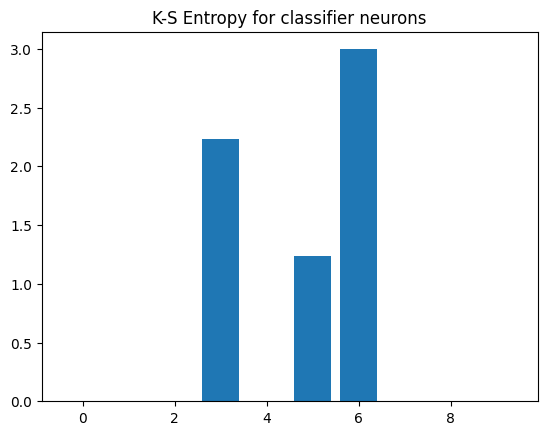


Анализ эмбеддингов:
K-S энтропия для слоя patch_embed: 0.0000


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Исправленная функция расчета энтропии
def calculate_ks_entropy(activations, m=3, tau=1, r_factor=0.2):
    """Расчет K-S энтропии для многомерных активаций"""
    # Преобразуем в 2D массив (samples, features)
    if activations.ndim > 2:
        activations = activations.reshape(activations.shape[0], -1)

    # Нормализация
    data = (activations - np.mean(activations, axis=0)) / np.std(activations, axis=0)

    # Параметры анализа
    r = r_factor * np.std(data)
    n_samples = len(data)

    # Реконструкция фазового пространства
    emb = np.array([data[i:i+(m-1)*tau+1:tau].flatten()
                  for i in range(n_samples-(m-1)*tau)])

    if len(emb) < 2:
        return 0.0

    # Расчет корреляционного интеграла
    try:
        dist = squareform(pdist(emb, 'chebyshev'))
        C = (np.sum(dist < r) - n_samples) / (n_samples*(n_samples-1))
        return np.log(C) if C > 0 else 0.0
    except:
        return 0.0

# 2. Адаптированная функция анализа слоев ViT
def analyze_vit_entropy(model, dataloader, layer_name='lin', num_samples=100):
    """Анализ энтропии для слоев ViT"""
    activations = []

    # Хук для сбора активаций
    def hook_fn(module, input, output):
        activations.append(output.detach().cpu().numpy())

    # Регистрация хука
    layer = dict(model.named_modules())[layer_name]
    hook = layer.register_forward_hook(hook_fn)

    # Проход данных
    with torch.no_grad():
        for images, _ in dataloader:
            if torch.cuda.is_available():
                images = images.cuda()
            model(images)
            if len(activations) * images.size(0) > num_samples:
                break

    hook.remove()

    if not activations:
        print("Нет данных для анализа")
        return 0.0

    activations = np.concatenate(activations)

    # Для линейного слоя анализируем нейроны
    if activations.ndim == 2:
        entropies = []
        for i in range(min(10, activations.shape[1])):  # Первые 10 нейронов
            E1 = calculate_ks_entropy(activations[:, i], m=3, tau=1)
            E2 = calculate_ks_entropy(activations[:, i], m=4, tau=1)
            entropies.append(max(0, E1 - E2))

        plt.bar(range(len(entropies)), entropies)
        plt.title(f'K-S Entropy for {layer_name} neurons')
        plt.show()
        return np.mean(entropies)

    # Для многомерных активаций (например, эмбеддингов)
    else:
        ks = calculate_ks_entropy(activations)
        print(f"K-S энтропия для слоя {layer_name}: {ks:.4f}")
        return ks

# 3. Модифицированная ViT модель
class VIT(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_size = 4
        self.hidden_dim = 64
        self.num_heads = 4

        # Патч-эмбеддинг
        self.patch_embed = nn.Conv2d(3, self.hidden_dim,
                                   kernel_size=self.patch_size,
                                   stride=self.patch_size)

        # Трансформер
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.hidden_dim,
            nhead=self.num_heads,
            dim_feedforward=256)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # Классификатор
        self.classifier = nn.Linear(self.hidden_dim, 10)

    def forward(self, x):
        # Патч-эмбеддинг
        x = self.patch_embed(x)  # [B, C, H, W]
        x = x.flatten(2).transpose(1, 2)  # [B, N, C]

        # Трансформер
        x = self.transformer(x)

        # Классификация (берем [CLS] токен)
        return self.classifier(x.mean(dim=1))

# 4. Пример использования
if __name__ == "__main__":
    # Подготовка данных
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Инициализация модели
    model = VIT()
    if torch.cuda.is_available():
        model.cuda()

    # Анализ слоев
    print("Анализ классификатора:")
    analyze_vit_entropy(model, train_loader, 'classifier')

    print("\nАнализ эмбеддингов:")
    analyze_vit_entropy(model, train_loader, 'patch_embed')

Training for 1 batch...

Analyzing stability...
Analyzing layer: patch_embed.proj
Max Lyapunov: 2.1586
Analyzing layer: transformer.norm1
Max Lyapunov: 2.0930
Analyzing layer: transformer.attention.W_Q
Max Lyapunov: 1.5132
Analyzing layer: transformer.attention.W_O
Max Lyapunov: 1.0168
Analyzing layer: transformer.ff.net.0
Max Lyapunov: 2.4567
Analyzing layer: transformer.ff.net.2
Max Lyapunov: 0.6110
Analyzing layer: classifier
Max Lyapunov: -2.1837


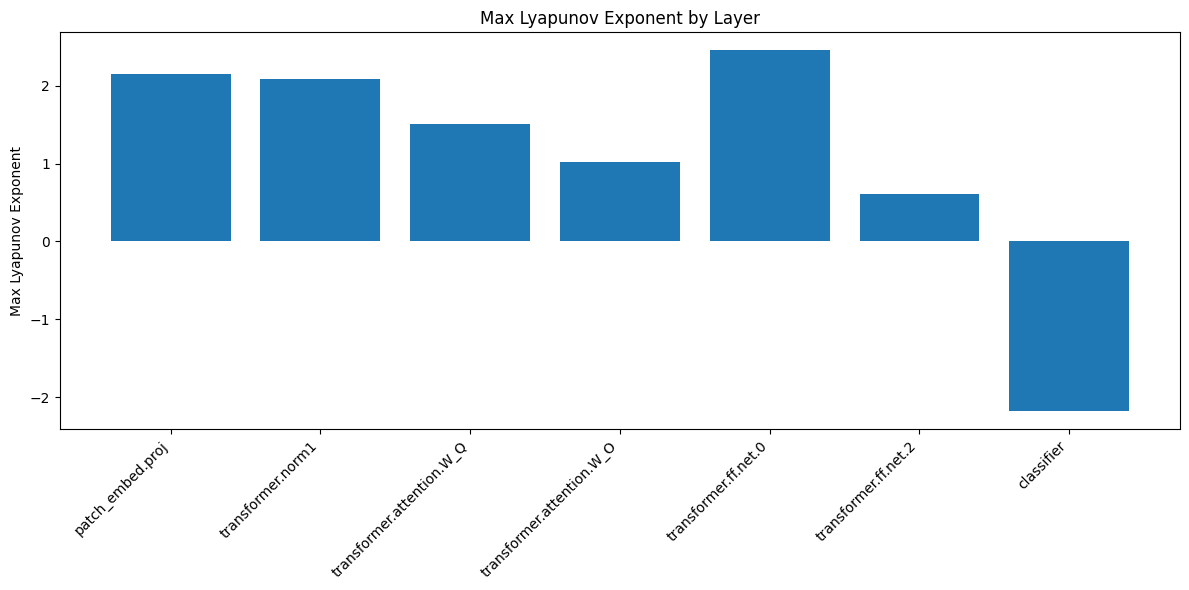

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from scipy.linalg import eigvalsh  # Using eigvalsh for symmetric matrices
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import torch.optim as optim

# Hyperparameters
batch_size = 16
embed_dim = 64
num_heads = 4
dropout = 0.1
num_classes = 10

# ViT Implementation (unchanged from original)
class PatchEmbeddingWithCLS(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=64):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)  # [B, E, H/P, W/P]
        x = x.flatten(2).transpose(1, 2)  # [B, N, E]

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        return x

class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.ReLU(),
            nn.Linear(4 * embed_dim, embed_dim),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)

class MultiHeadAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.d_model = embed_dim
        self.num_heads = num_heads
        self.d_k = embed_dim // num_heads

        self.W_Q = nn.Linear(embed_dim, embed_dim)
        self.W_K = nn.Linear(embed_dim, embed_dim)
        self.W_V = nn.Linear(embed_dim, embed_dim)
        self.W_O = nn.Linear(embed_dim, embed_dim)

    def forward(self, Q, K, V):
        B = Q.size(0)

        Q = self.W_Q(Q).view(B, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_K(K).view(B, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_V(V).view(B, -1, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        weights = F.softmax(scores, dim=-1)
        output = torch.matmul(weights, V)

        output = output.transpose(1, 2).contiguous().view(B, -1, self.d_model)
        return self.W_O(output)

class TransformerEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.attention = MultiHeadAttention()
        self.ff = FeedForward()

    def forward(self, x):
        x_norm = self.norm1(x)
        attn_out = self.attention(x_norm, x_norm, x_norm)
        x = x + attn_out

        x_norm = self.norm2(x)
        ff_out = self.ff(x_norm)
        x = x + ff_out
        return x

class ViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = PatchEmbeddingWithCLS()
        self.transformer = TransformerEncoder()
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.transformer(x)
        cls_token = x[:, 0]  # Take only CLS token for classification
        return self.classifier(cls_token)

# Improved Stability Analyzer
class StabilityAnalyzer:
    def __init__(self, model):
        self.model = model

    def get_activations(self, layer_name, dataloader, n_samples=100):
        activations = []

        def hook(module, input, output):
            # Flatten the activations to 2D (batch_size, features)
            flattened = output.view(output.size(0), -1).detach().cpu().numpy()
            activations.append(flattened)

        layer = dict(self.model.named_modules())[layer_name]
        handle = layer.register_forward_hook(hook)

        with torch.no_grad():
            for images, _ in dataloader:
                self.model(images)
                if len(activations) * images.size(0) >= n_samples:
                    break

        handle.remove()
        activations = np.concatenate(activations)[:n_samples]
        return activations

    def lyapunov_exponents(self, activations):
        # Compute covariance matrix
        cov_matrix = np.cov(activations, rowvar=False)
        # Use eigvalsh for symmetric matrices
        eigenvalues = eigvalsh(cov_matrix)
        eigenvalues = np.sort(eigenvalues)[::-1]  # Sort descending
        # Avoid log(0)
        eigenvalues = np.maximum(eigenvalues, 1e-12)
        return np.log(eigenvalues) / 2

    def fractal_dimension(self, activations, k=5, n_samples=500):
        if len(activations) > n_samples:
            activations = activations[np.random.choice(len(activations), n_samples, replace=False)]

        if activations.shape[1] > 50:
            tsne = TSNE(n_components=2, perplexity=30)
            data = tsne.fit_transform(activations)
        else:
            data = activations

        nbrs = NearestNeighbors(n_neighbors=k+1).fit(data)
        distances, _ = nbrs.kneighbors(data)
        distances = distances[:, k]

        r = np.linspace(np.min(distances), np.max(distances), 20)
        C = [np.sum(distances < radius) / len(distances) for radius in r]

        log_r = np.log(r[r > 0])
        log_C = np.log(np.array(C)[r > 0] + 1e-12)
        return np.polyfit(log_r, log_C, 1)[0]

    def analyze(self, dataloader):
        results = {}

        # Focus on key layers
        target_layers = [
            'patch_embed.proj',
            'transformer.norm1',
            'transformer.attention.W_Q',
            'transformer.attention.W_O',
            'transformer.ff.net.0',
            'transformer.ff.net.2',
            'classifier'
        ]

        for layer_name in target_layers:
            try:
                print(f"Analyzing layer: {layer_name}")

                # Get activations
                activations = self.get_activations(layer_name, dataloader)

                # Lyapunov exponents
                lexp = self.lyapunov_exponents(activations)
                results[layer_name] = {
                    'max_lyapunov': max(lexp),
                    'lyapunov_exponents': lexp
                }

                # Fractal dimension
                if len(activations) > 100:
                    fd = self.fractal_dimension(activations)
                    results[layer_name]['fractal_dim'] = fd
                    print(f"Fractal dimension: {fd:.2f}")

                print(f"Max Lyapunov: {max(lexp):.4f}")

            except Exception as e:
                print(f"Error analyzing {layer_name}: {str(e)}")

        return results

# Training and analysis
if __name__ == "__main__":
    # Prepare data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Initialize model
    model = ViT()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train for 1 batch
    print("Training for 1 batch...")
    model.train()
    images, labels = next(iter(trainloader))
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Analyze stability
    print("\nAnalyzing stability...")
    analyzer = StabilityAnalyzer(model)
    results = analyzer.analyze(trainloader)

    # Visualization
    if results:
        layers = list(results.keys())
        max_lexp = [results[l]['max_lyapunov'] for l in layers]

        plt.figure(figsize=(12, 6))
        plt.bar(range(len(layers)), max_lexp, tick_label=layers)
        plt.xticks(rotation=45, ha='right')
        plt.title('Max Lyapunov Exponent by Layer')
        plt.ylabel('Max Lyapunov Exponent')
        plt.tight_layout()
        plt.show()

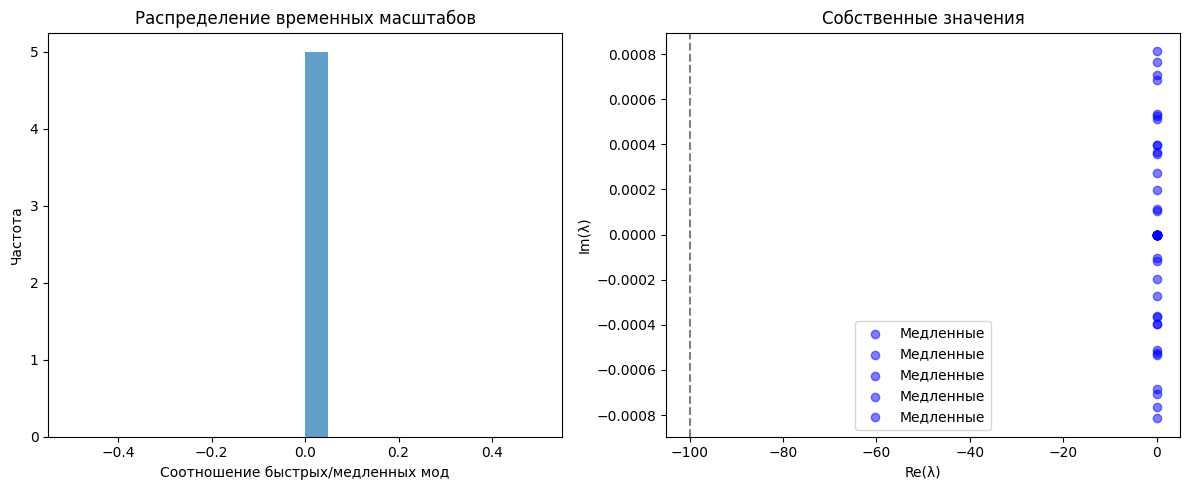

Среднее соотношение быстрых/медленных мод: 0.00
Общее количество проанализированных образцов: 5


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from scipy.linalg import eigvals
import matplotlib.pyplot as plt

class PatchEmbeddingWithCLS(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=64):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)  # [B, E, H/P, W/P]
        x = x.flatten(2).transpose(1, 2)  # [B, N, E]

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=64, num_heads=4):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim=64, num_heads=4):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(),
            nn.Linear(4 * embed_dim, embed_dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class ViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3,
                 embed_dim=64, num_heads=4, num_layers=4, num_classes=10):
        super().__init__()
        self.patch_embed = PatchEmbeddingWithCLS(img_size, patch_size, in_chans, embed_dim)
        self.encoder = nn.Sequential(*[
            TransformerEncoder(embed_dim, num_heads) for _ in range(num_layers)
        ])
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        cls_token = x[:, 0]  # Take CLS token for classification
        return self.head(cls_token)

# Пример использования с анализатором
if __name__ == "__main__":
    # 1. Настройка устройства
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 2. Создание модели ViT
    model = ViT(
        img_size=32,
        patch_size=4,
        in_chans=3,
        embed_dim=64,
        num_heads=4,
        num_layers=4,
        num_classes=10
    ).to(device)

    # 3. Загрузка данных CIFAR-10
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # 4. Анализ сингулярных возмущений
    analyzer = SingularPerturbationAnalyzer(model, eps=1e-2, device=device)
    time_scales = analyzer.analyze_time_scales(train_loader, n_samples=5)
    analyzer.visualize_results(time_scales)

    # 5. Статистика
    if time_scales:
        avg_ratio = np.mean([ts['ratio'] for ts in time_scales if 'ratio' in ts])
        print(f"Среднее соотношение быстрых/медленных мод: {avg_ratio:.2f}")
        print(f"Общее количество проанализированных образцов: {len(time_scales)}")
    else:
        print("Не удалось проанализировать ни одного образца")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbeddingWithCLS(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=64):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)  # [B, E, H/P, W/P]
        x = x.flatten(2).transpose(1, 2)  # [B, N, E]

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=64, num_heads=4):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim=64, num_heads=4):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(),
            nn.Linear(4 * embed_dim, embed_dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class ViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3,
                 embed_dim=64, num_heads=4, num_layers=4, num_classes=10,
                 activation_gain=1.0, weight_scale=1.0):
        super().__init__()
        self.activation_gain = activation_gain
        self.weight_scale = weight_scale

        self.patch_embed = PatchEmbeddingWithCLS(img_size, patch_size, in_chans, embed_dim)
        self.encoder = nn.Sequential(*[
            TransformerEncoder(embed_dim, num_heads) for _ in range(num_layers)
        ])
        self.head = nn.Linear(embed_dim, num_classes)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0,
                              std=self.weight_scale/np.sqrt(m.weight.shape[1]))
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0,
                              std=self.weight_scale/np.sqrt(m.weight.shape[1]*m.weight.shape[2]*m.weight.shape[3]))

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        cls_token = x[:, 0]  # Take CLS token for classification
        return self.head(cls_token) * self.activation_gain

Analyzing activation gain...


Analyzing bifurcations: 100%|██████████| 10/10 [00:00<00:00, 426.38it/s]


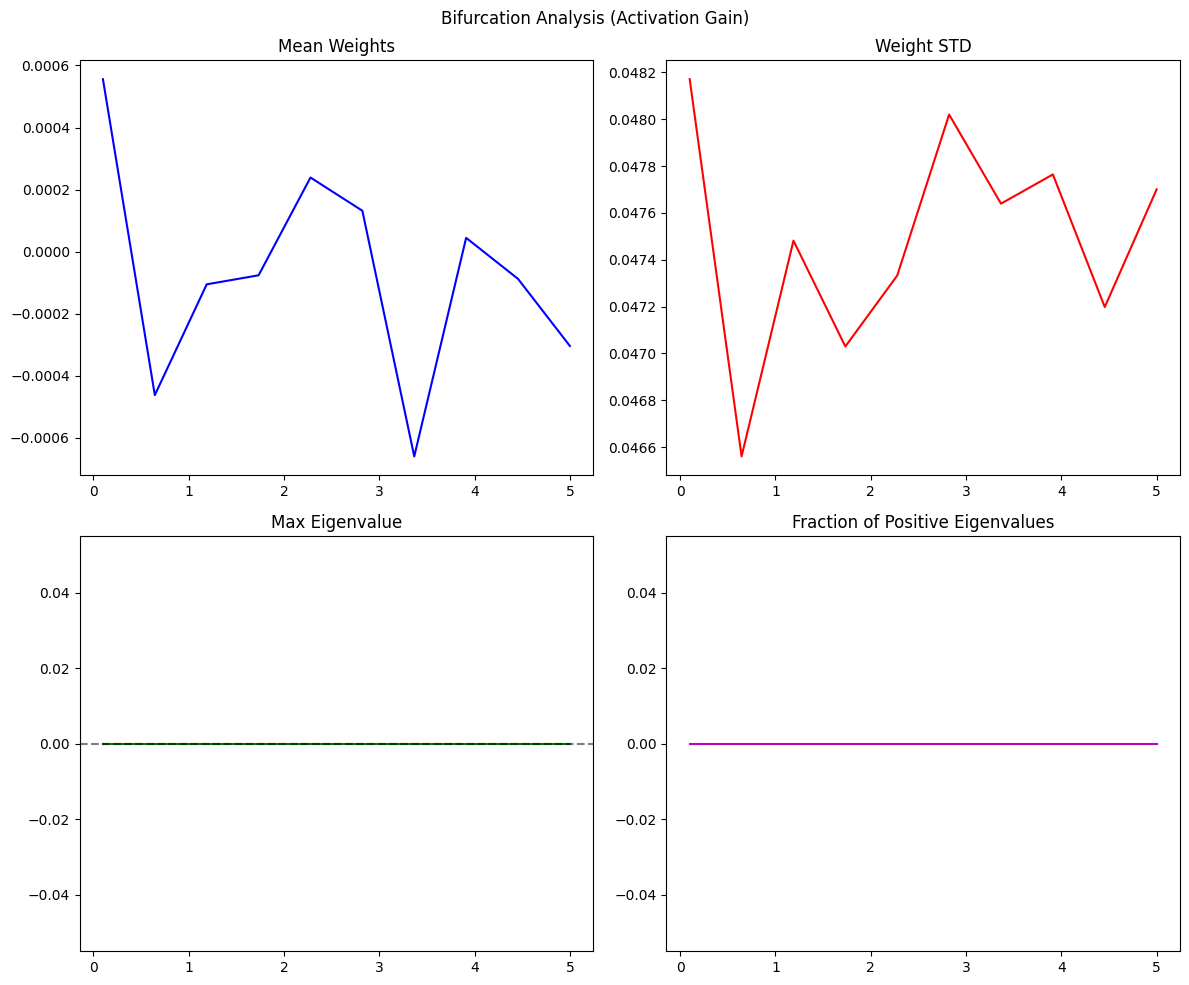

Analyzing weight scale...


Analyzing bifurcations: 100%|██████████| 10/10 [00:00<00:00, 315.74it/s]


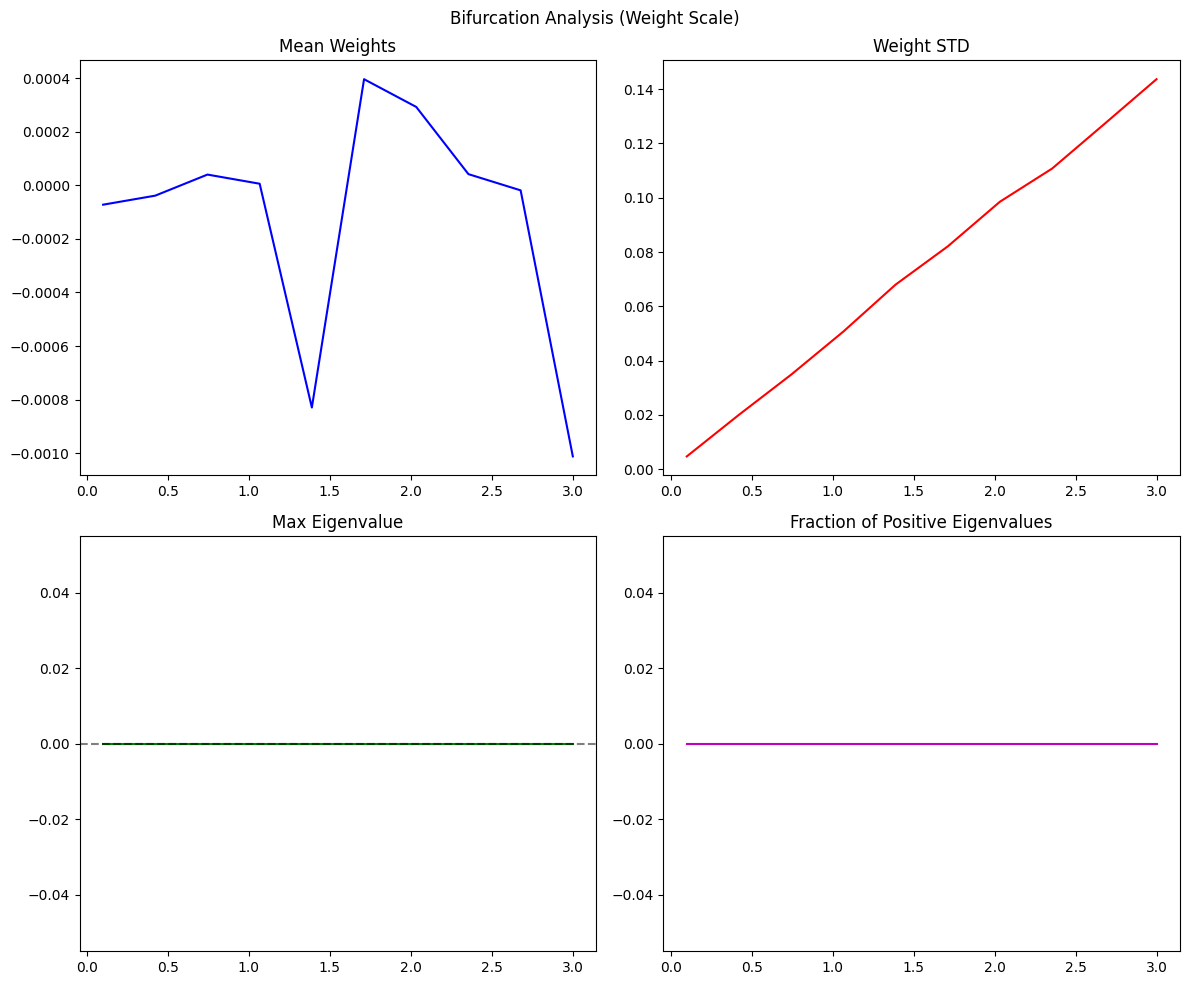

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from scipy.linalg import eigvals
import matplotlib.pyplot as plt
from tqdm import tqdm

class BifurcationAnalyzer:
    def __init__(self, model_class, device='cuda'):
        self.model_class = model_class
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

    def generate_bifurcation_data(self, param_name, param_range, dataloader, n_samples=5):
        """Генерация данных о бифуркациях"""
        results = []

        for param_value in tqdm(param_range, desc='Analyzing bifurcations'):
            model = self.model_class(**{param_name: param_value}).to(self.device)
            dynamics = self._analyze_dynamics(model, dataloader, n_samples)
            results.append((param_value, dynamics))

        return results

    def _analyze_dynamics(self, model, dataloader, n_samples):
        """Анализ динамики через веса модели"""
        model.eval()
        dynamics = {
            'mean_weight': 0,
            'weight_std': 0,
            'max_eigenvalue': 0,
            'positive_eigs': 0
        }

        # Собираем все веса модели
        weights = []
        for name, param in model.named_parameters():
            if 'weight' in name:
                weights.append(param.detach().cpu().numpy().flatten())

        if len(weights) == 0:
            return dynamics

        weights = np.concatenate(weights)

        # Вычисляем статистики весов
        dynamics['mean_weight'] = np.mean(weights)
        dynamics['weight_std'] = np.std(weights)

        # Для матрицы Якобиана используем ковариационную матрицу весов
        if len(weights) > 1000:  # Ограничим размер для скорости
            weights = np.random.choice(weights, 1000, replace=False)

        cov_matrix = np.cov(weights.reshape(-1, 1), rowvar=False)
        try:
            eigenvalues = eigvals(cov_matrix)
            real_parts = np.real(eigenvalues)
            dynamics['max_eigenvalue'] = np.max(real_parts)
            dynamics['positive_eigs'] = np.sum(real_parts > 0) / len(real_parts)
        except:
            pass

        return dynamics

    def plot_bifurcation_diagram(self, results, param_name):
        """Визуализация результатов"""
        params = [r[0] for r in results]
        metrics = [r[1] for r in results]

        fig, axs = plt.subplots(2, 2, figsize=(12, 10))

        # 1. Среднее значение весов
        axs[0,0].plot(params, [m['mean_weight'] for m in metrics], 'b-')
        axs[0,0].set_title('Mean Weights')

        # 2. Стандартное отклонение весов
        axs[0,1].plot(params, [m['weight_std'] for m in metrics], 'r-')
        axs[0,1].set_title('Weight STD')

        # 3. Максимальное собственное значение
        axs[1,0].plot(params, [m['max_eigenvalue'] for m in metrics], 'g-')
        axs[1,0].axhline(0, color='k', linestyle='--', alpha=0.5)
        axs[1,0].set_title('Max Eigenvalue')

        # 4. Доля положительных собственных значений
        axs[1,1].plot(params, [m['positive_eigs'] for m in metrics], 'm-')
        axs[1,1].set_title('Fraction of Positive Eigenvalues')

        plt.suptitle(f'Bifurcation Analysis ({param_name})')
        plt.tight_layout()
        plt.show()

# Упрощенная модель для анализа
class SimpleCNN(nn.Module):
    def __init__(self, activation_gain=1.0, weight_scale=1.0):
        super().__init__()
        self.activation_gain = activation_gain
        self.weight_scale = weight_scale

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc = nn.Linear(32*8*8, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        # Инициализация весов
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0,
                              std=self.weight_scale/np.sqrt(m.weight.shape[1]*9))
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0,
                              std=self.weight_scale/np.sqrt(m.weight.shape[1]))

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x) * self.activation_gain

if __name__ == "__main__":
    # 1. Загрузка данных CIFAR-10
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # 2. Анализ бифуркаций
    analyzer = BifurcationAnalyzer(SimpleCNN)

    print("Analyzing activation gain...")
    activation_gains = np.linspace(0.1, 5.0, 10)
    results = analyzer.generate_bifurcation_data('activation_gain', activation_gains, train_loader)
    analyzer.plot_bifurcation_diagram(results, 'Activation Gain')

    print("Analyzing weight scale...")
    weight_scales = np.linspace(0.1, 3.0, 10)
    results = analyzer.generate_bifurcation_data('weight_scale', weight_scales, train_loader)
    analyzer.plot_bifurcation_diagram(results, 'Weight Scale')